In [1]:
import tensorrt
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

#tf.config.run_functions_eagerly(False)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

In [3]:
# Utility functions
def get_vacuum_state_tf(dim):
    vacuum_state = qt.basis(dim, 0)
    return tf.convert_to_tensor(vacuum_state.full(), dtype=tf.complex64)

def annihilation(dim):
    diag_vals = tf.math.sqrt(tf.cast(tf.range(1, dim), dtype=tf.complex64))
    return tf.linalg.diag(diag_vals, k=1)

def number(dim):
    diag_vals = tf.cast(tf.range(0, dim), dtype=tf.complex64)
    return tf.linalg.diag(diag_vals)

def displacement_operator(dim, x, y=0):
    x2 = tf.identity(x)
    y2 = tf.identity(y)
    alpha = tf.complex(x2, y2)
    a = annihilation(dim)
    term1 = alpha * tf.linalg.adjoint(a)
    term2 = tf.math.conj(alpha) * a
    D = tf.linalg.expm(term1 - term2)
    return D

def displacement_encoding(dim, alpha_vec):
    alpha_vec = tf.cast(alpha_vec, dtype=tf.complex64)
    num = tf.shape(alpha_vec)[0]
    a = annihilation(dim)
    term1 = tf.linalg.adjoint(a)
    term2 = a
    term1_batch = tf.tile(tf.expand_dims(term1, 0), [num, 1, 1])
    term2_batch = tf.tile(tf.expand_dims(term2, 0), [num, 1, 1])
    alpha_vec = tf.reshape(alpha_vec, [-1, 1, 1])
    D = tf.linalg.expm(alpha_vec * term1_batch - tf.math.conj(alpha_vec) * term2_batch)
    return D

def rotation_operator(dim, theta):
    theta2 = tf.identity(theta)
    theta2 = tf.cast(theta2, dtype=tf.complex64)
    n = number(dim)
    R = tf.linalg.expm(-1j * theta2 * n)
    return R

def squeezing_operator(dim, r):
    r2 = tf.identity(r)
    r2 = tf.cast(r2, dtype=tf.complex64)
    a = annihilation(dim)
    term1 = r2 * tf.linalg.adjoint(a) * a
    term2 = tf.math.conj(r2) * a * tf.linalg.adjoint(a)
    S = tf.linalg.expm(0.5 * (term1 - term2))
    return S

def kerr_operator(dim, kappa):
    kappa2 = tf.identity(kappa)
    kappa2 = tf.cast(kappa2, dtype=tf.complex64)
    n = number(dim)
    K = tf.linalg.expm(1j * kappa2 * n * n)

    return K

In [4]:
# TensorFlow Custom Layer for Quantum Encoding
class QEncoder(tf.keras.layers.Layer):
    def __init__(self, dim, vacuum_state, **kwargs):
        super(QEncoder, self).__init__(**kwargs)
        self.dim = dim
        self.vacuum_state = tf.cast(vacuum_state, dtype=tf.complex64)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_vacuum_state = tf.tile(tf.expand_dims(self.vacuum_state, axis=0), [batch_size, 1, 1])
        batch_displacement_operators = displacement_encoding(self.dim, inputs)
        displaced_states = tf.einsum('bij,bjk->bik', batch_displacement_operators, batch_vacuum_state)
        return displaced_states


# TensorFlow Custom Layer for Quantum Transformations
class QLayer(tf.keras.layers.Layer):
    def __init__(self, dim, stddev=0.1, **kwargs):
        super(QLayer, self).__init__(**kwargs)
        self.dim = dim
        self.stddev = stddev  # Standard deviation as a hyperparameter

    def build(self, input_shape):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=self.stddev, seed=None)
        self.theta_1 = self.add_weight("theta_1", shape=[1,], initializer=initializer, trainable=True)
        self.theta_2 = self.add_weight("theta_2", shape=[1,], initializer=initializer, trainable=True)
        self.r = self.add_weight("r", shape=[1,], initializer=initializer, trainable=True)
        self.bx = self.add_weight("bx", shape=[1,], initializer=initializer, trainable=True)
        self.bp = self.add_weight("bp", shape=[1,], initializer=initializer, trainable=True)
        self.kappa = self.add_weight("kappa", shape=[1,], initializer=initializer, trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        D_tensor = tf.expand_dims(displacement_operator(self.dim, self.bx, self.bp), 0)
        R_tensor_1 = tf.expand_dims(rotation_operator(self.dim, self.theta_1), 0)
        S_tensor = tf.expand_dims(squeezing_operator(self.dim, self.r), 0)
        R_tensor_2 = tf.expand_dims(rotation_operator(self.dim, self.theta_2), 0)
        K_tensor = tf.expand_dims(kerr_operator(self.dim, self.kappa), 0)

        D_tensor = tf.tile(D_tensor, [batch_size, 1, 1])
        R_tensor_1 = tf.tile(R_tensor_1, [batch_size, 1, 1])
        S_tensor = tf.tile(S_tensor, [batch_size, 1, 1])
        R_tensor_2 = tf.tile(R_tensor_2, [batch_size, 1, 1])
        K_tensor = tf.tile(K_tensor, [batch_size, 1, 1])

        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_1, inputs)
        transformed_state = tf.einsum('bij,bjk->bik', S_tensor, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_2, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', D_tensor, transformed_state)
        activated_state = tf.einsum('bij,bjk->bik', K_tensor, transformed_state)
        
        self.final_state = activated_state
        return activated_state
    
    
# TensorFlow Custom Layer for Quantum Decoding
class QDecoder(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super(QDecoder, self).__init__(**kwargs)
        self.dim = dim
        self.x_operator = self.build_x_operator()

    def build_x_operator(self):
        a = annihilation(self.dim)
        x_operator = (a + tf.linalg.adjoint(a)) / 2.0
        x_operator = tf.expand_dims(x_operator, axis=0)  # Add batch dimension
        return x_operator

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_x_operator = tf.tile(self.x_operator, [batch_size, 1, 1])

        # Step 1: Compute \hat{O} | \psi \rangle for each state in the batch
        operator_applied_state = tf.einsum('bij,bjk->bik', batch_x_operator, inputs)

        # Take the complex conjugate of each state and adjust dimensions
        conj_inputs = tf.math.conj(inputs)  # Shape: (batch_size, dim, 1)
        conj_inputs_adj = tf.transpose(conj_inputs, perm=[0, 2, 1])  # Shape: (batch_size, 1, dim)

        # Compute the expectation value (inner product) for each state in the batch
        x_expectation = tf.einsum('bij,bjk->bi', conj_inputs_adj, operator_applied_state) 
        x_expectation = tf.squeeze(x_expectation, axis=-1)

        return tf.math.real(x_expectation)

# TensorFlow Custom Callback for Progress Bars
from IPython.display import clear_output

class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch += 1  # epochs are zero-indexed in this method
        loss = logs.get('loss')

        print("Iter: {:5d} | Loss: {:0.7f}".format(epoch, loss))

        # Every 5 epochs, clear the screen
        if epoch % 5 == 0:
            clear_output(wait=True)

# TensorFlow Custom Callback for Parameter Logging
class ParameterLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, fold, function_index, x_train, y_train, base_dir='Params'):
        super(ParameterLoggingCallback, self).__init__()
        self.fold = fold
        self.function_index = function_index
        self.x_train = x_train
        self.y_train = y_train
        self.base_dir = base_dir
        self.params_dir = os.path.join(base_dir, f'Function_{function_index}')
        self.filename = os.path.join(self.params_dir, f'parameters_fold_{fold}.csv')
        self.epoch = 0
        
        # Create directory if it doesn't exist
        os.makedirs(self.params_dir, exist_ok=True)
        
    def on_train_begin(self, logs=None):
        # Create the CSV file for parameters and write the header
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Epoch', 'theta_1', 'r', 'theta_2', 'bx', 'bp', 'kappa'])
        
        # Create a CSV file for training data
        train_data_file = os.path.join(self.params_dir, f'train_data_fold_{self.fold}.csv')
        with open(train_data_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['x', 'y'])
            for x, y in zip(self.x_train, self.y_train):
                # Assuming x is a single real number and y is the target (expected output)
                writer.writerow([x, y])
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        params = []
        for layer in self.model.layers:
            if isinstance(layer, QLayer):
                params.extend([
                    layer.theta_1.numpy()[0],
                    layer.r.numpy()[0],
                    layer.theta_2.numpy()[0],
                    layer.bx.numpy()[0],
                    layer.bp.numpy()[0],
                    layer.kappa.numpy()[0]
                ])
        
        # Append the parameters to the CSV file
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([self.epoch] + params)

In [5]:
def f1(x, eps=0.0):
    """The function f(x)=|x|+noise"""
    return np.abs(x) + eps * np.random.normal(size=x.shape)


def f2(x, eps=0.0):
    """The function f(x)=sin(pi*x)/(pi*x)+noise"""
    return np.sin(x*np.pi)/(np.pi*x) + eps * np.random.normal(size=x.shape)


def f3(x, eps=0.0):
    """The function f(x)=exp(x)+noise"""
    return np.exp(x) + eps * np.random.normal(size=x.shape)


def f4(x, eps=0.0):
    """The function f(x)=tanh(4x)+noise"""
    return np.tanh(4*x) + eps * np.random.normal(size=x.shape)


def f5(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return x**3 + eps * np.random.normal(size=x.shape)

In [6]:
# Prepare your dataset
x = np.linspace(-np.pi, np.pi, 300).reshape(-1, 1)
F = [f1, f2, f3, f4, f5]
Y = np.array([f(x, eps=0.1) for f in F])

def min_max_normalize(data):
    min_val = data.min(axis=1, keepdims=True)
    max_val = data.max(axis=1, keepdims=True)
    return (data - min_val) / (max_val - min_val)

# Normalize each result individually
Y = min_max_normalize(Y)

In [7]:
from sklearn.model_selection import KFold

def train_model(input_data, target_data, function_index, k_folds=5, std=0.1, cutoff_dim=10, num_layers=6, epochs=200):
    fold_var = 1
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    print(f'Training model for Function {function_index} with {num_layers} layers for {epochs} epochs...')
    
    for train_index, val_index in kf.split(input_data):
        # Split data into training and validation for the current fold
        x_train_fold, x_val_fold = input_data[train_index], input_data[val_index]
        y_train_fold, y_val_fold = target_data[train_index], target_data[val_index]

        # Create a new model for each fold
        vacuum_state = get_vacuum_state_tf(cutoff_dim)
        model = tf.keras.Sequential([QEncoder(dim=cutoff_dim, vacuum_state=vacuum_state, name='QuantumEncoding')])
        for i in range(num_layers):
            model.add(QLayer(dim=cutoff_dim, stddev=std, name=f'QuantumLayer_{i+1}'))
        model.add(QDecoder(dim=cutoff_dim, name='QuantumDecoding'))

        # Compile the model
        opt = tf.keras.optimizers.Adam(0.01, clipnorm=1.0)
        model.compile(optimizer=opt, loss='mse')
        
        # Create the ParameterLoggingCallback
        param_logger = ParameterLoggingCallback(fold_var, function_index, x_train_fold, y_train_fold)
        
        # Train the model
        print(f'Training on fold {fold_var}...')
        history = model.fit(x_train_fold, y_train_fold, validation_data=(x_val_fold, y_val_fold), 
                            epochs=epochs, verbose=0, callbacks=[TrainingProgress(), param_logger])

        print(f'Training on fold {fold_var} complete.')
        fold_var += 1

    print('Training Complete.')
    model.summary()

    return history, model

In [8]:
def untrained_models(d = 0.1, num_layers = 6, cutoff_dim = 10):
    models = []
    vacuum_state = get_vacuum_state_tf(cutoff_dim)
    
    for _ in range(5):
        model = tf.keras.Sequential([QEncoder(dim=cutoff_dim, vacuum_state=vacuum_state, name='QuantumEncoding')])
        for i in range(num_layers):
            model.add(QLayer(dim=cutoff_dim, stddev=d, name=f'QuantumLayer_{i+1}'))
        model.add(QDecoder(dim=cutoff_dim, name='QuantumDecoding'))

        # Compile the model
        model.compile(optimizer='Adam', loss='mse')
        models.append(model)

    return models    

In [9]:
# Train the model
results = []
for y in Y:
    results.append(train_model(x, y, std=0.1, num_layers=4, cutoff_dim=15))
H, M = zip(*results)

Training on fold 5 complete.
Training Complete.
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 QuantumEncoding (QEncoder)  (None, 15, 1)             0         
                                                                 
 QuantumLayer_1 (QLayer)     (None, 15, 1)             6         
                                                                 
 QuantumLayer_2 (QLayer)     (None, 15, 1)             6         
                                                                 
 QuantumLayer_3 (QLayer)     (None, 15, 1)             6         
                                                                 
 QuantumLayer_4 (QLayer)     (None, 15, 1)             6         
                                                                 
 QuantumDecoding (QDecoder)  (None,)                   0         
                                                                 
Total

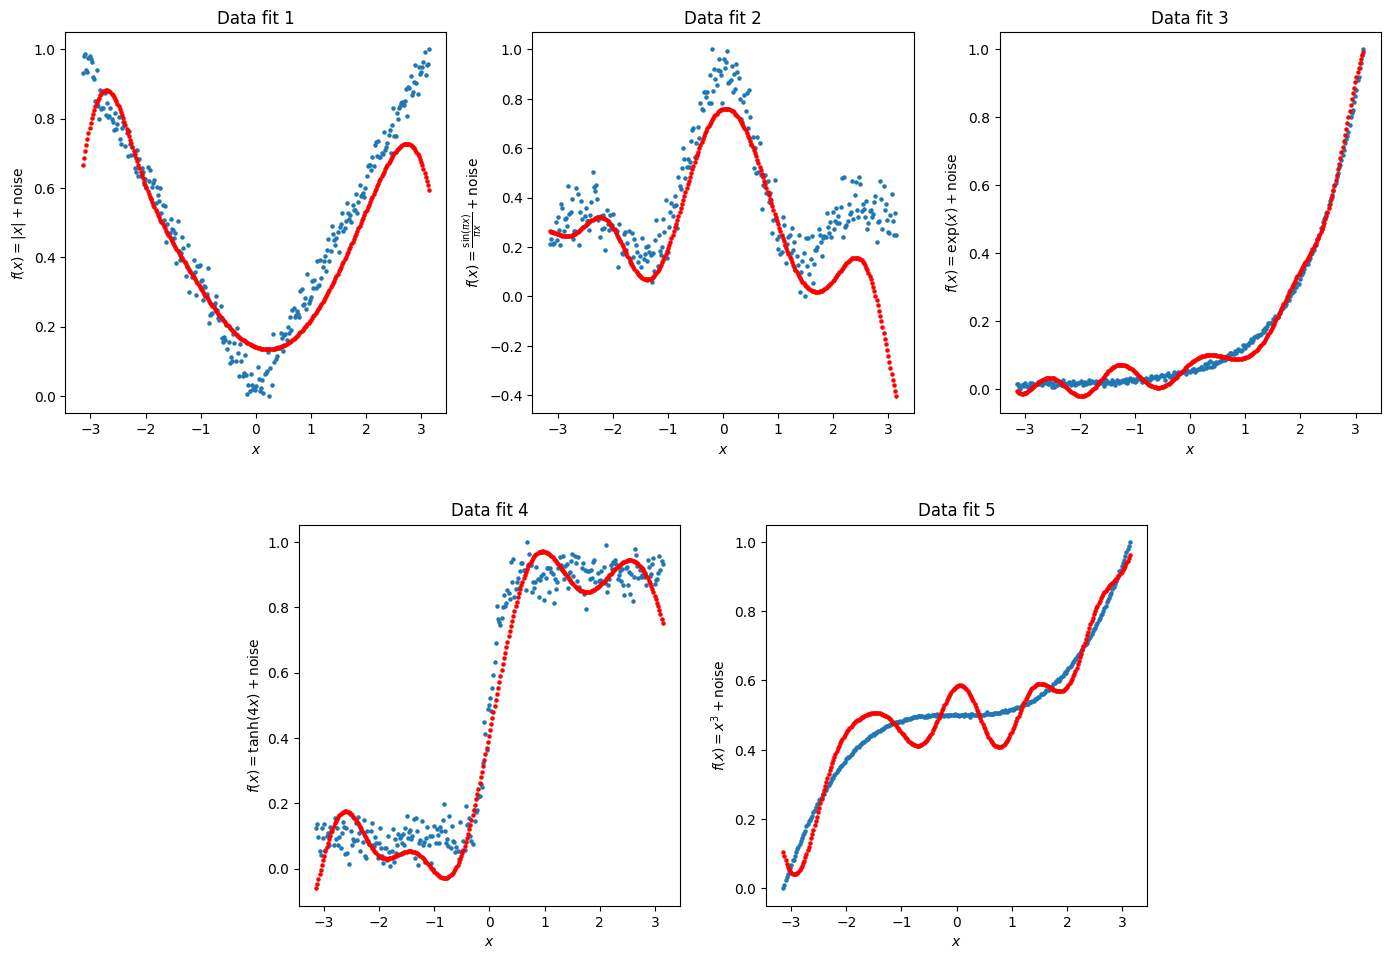

In [10]:
fit = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

Y_preds = [model.predict(x, verbose = 0) for model in M]
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \frac{\sin(\pi x)}{\pi x} + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \tanh(4x) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$'
]

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    y = Y[i]
    y_pred = Y_preds[i]
    ax.scatter(x, y, s=5, label="Noisy Data")
    ax.scatter(x, y_pred, s=5, label='Fitted Curve', color='r')
    ax.set_title(f'Data fit {i+1}')
    ax.set_xlabel(r'$x$') 
    ax.set_ylabel(y_labels[i])
    ax.set_box_aspect(1)

plt.tight_layout()
fit.savefig('fits.png')
plt.show()

stddevs = [0.]

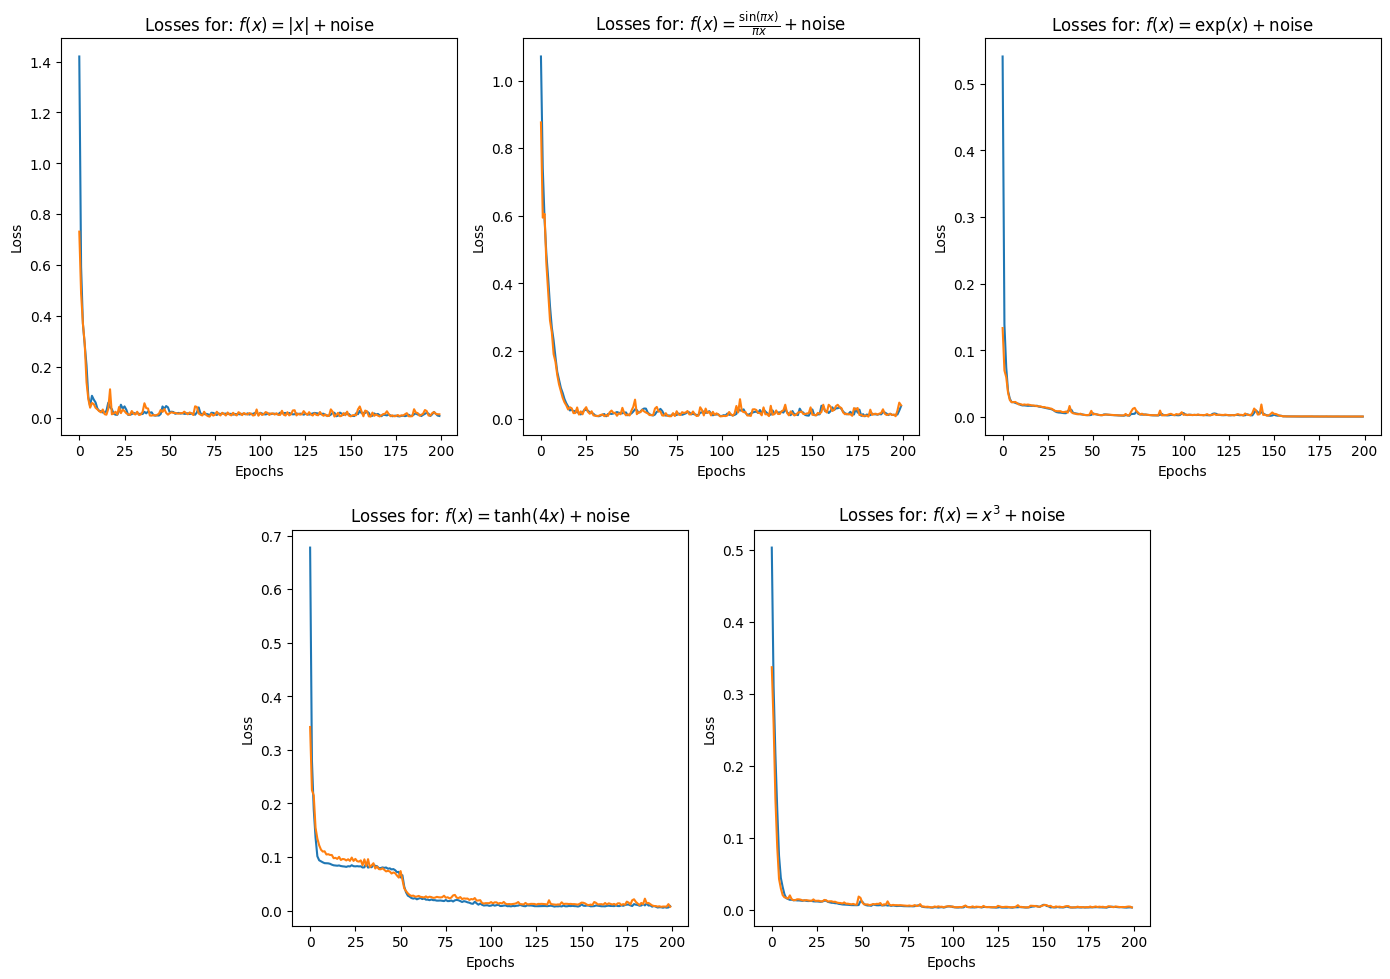

In [11]:
cost = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    ax.plot(H[i].history['loss'], label='Training Loss')
    ax.plot(H[i].history['val_loss'], label='Validation Loss')
    ax.set_title("Losses for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('Loss')
    ax.set_box_aspect(1)

plt.tight_layout()
fit.savefig('mse_with_val.png')
plt.show()

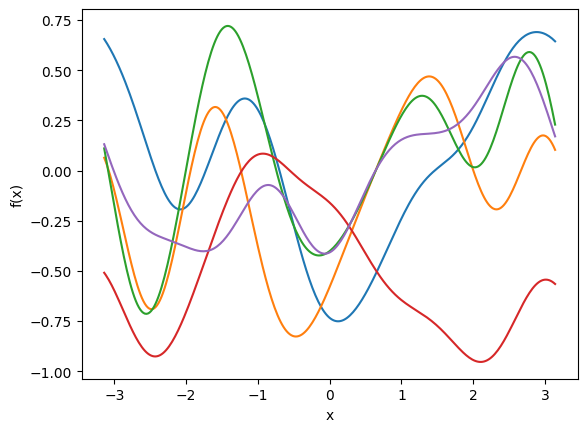

In [12]:
M = untrained_models(d = 0.5, num_layers=3)
plt.figure()
for i in range(len(M)):
    y_pred = M[i].predict(x, verbose = 0)
    plt.plot(x, y_pred)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()